In [15]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import json
%pylab inline


if os.getenv ('PUI2018') is None:
    print ("Must set env variable PUI2018")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")

Populating the interactive namespace from numpy and matplotlib
Must set env variable PUI2018


Idea: Customer (24-hour pass) are less likely than Subscriber (Annual Member) to choose biking for commuting

Null Hypothesis: The proportion of Subscriber biking on weekends is the same or higher than the proportion of Customer biking on weekends

Alternative Hypothesis: The proportion of Subscriber biking on weekends is less than the proportion of Customer biking on weekends

# _$H_0$_ : $\frac{C_{\mathrm{weekend}}}{C_{\mathrm{total}}} - \frac{S_{\mathrm{weekend}}}{S_{\mathrm{total}}} <= 0 $
 
# _$H_1$_ : $\frac{c_{\mathrm{weekend}}}{C_{\mathrm{total}}} - \frac{S_{\mathrm{weekend}}}{S_{\mathrm{total}}} > 0$

I will use a significance level  α=0.05α=0.05 
which means I want the probability of getting a result at least as significant as mine to be less then 5%

In [16]:
#I directly used this code from the example python notebook

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")
    else:
        print ("file in place, you can continue")

In [17]:
#initiate the data frame 
datestring = '201601'
getCitiBikeCSV(datestring)
df_1 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
datestring = '201602'
getCitiBikeCSV(datestring)
df_2 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')

frames = [df_1, df_2]
df = pd.concat(frames,ignore_index=True)
df['date'] = pd.to_datetime(df['starttime'],format="%m/%d/%Y %H:%M:%S")

file in place, you can continue
file in place, you can continue


In [18]:
#drop unnecessary columns
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid',
       'birth year', 'gender'], axis=1,inplace=True)

In [20]:
counts_s = df.date[df.usertype == 'Subscriber'].groupby([df.date.dt.weekday]).count()
error_s = np.sqrt(counts_s)
norm_s = counts_s.sum()

counts_c = df.date[df.usertype == 'Customer'].groupby([df.date.dt.weekday]).count()
error_c = np.sqrt(counts_c)
norm_c = counts_c.sum()

In [32]:
eweek_s

0.00087364259178389261

In [22]:
week_s = sum(counts_s[:-2]) * 1.0 / norm_s
week_c = sum(counts_c[:-2]) * 1.0 / norm_c

weekend_s = sum(counts_s[-2:]) * 1.0 / norm_s
weekend_c = sum(counts_c[-2:]) * 1.0 / norm_c

eweek_s = np.sqrt(sum(error_s[:-2]**2)) / norm_s  
eweek_c = np.sqrt(sum(error_c[:-2]**2)) / norm_c

eweekend_s = np.sqrt(sum(error_s[-2:]**2)) / norm_s 
eweekend_c = np.sqrt(sum(error_c[-2:]**2)) / norm_c

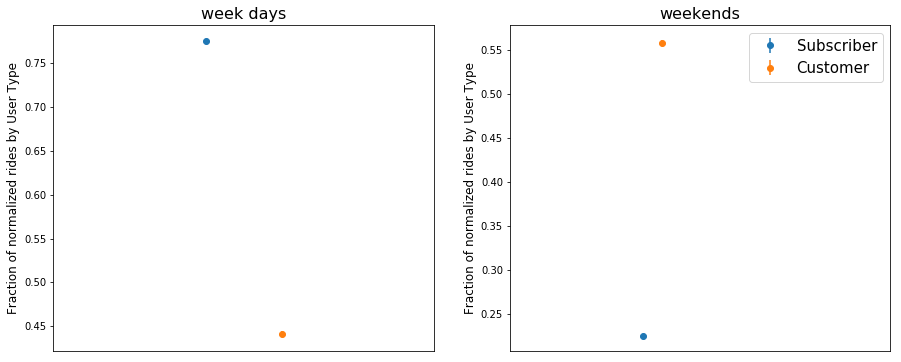

In [36]:
fig = pl.figure(figsize(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])


ax1.errorbar([0.2], [week_s], yerr=[eweek_s], fmt='o', label='Subscriber')
ax1.errorbar([0.3], [week_c], yerr=[eweek_c], fmt='o', label='Customer')
ax1.set_xlim(0, 0.5)
ax2.errorbar([0.2], [weekend_s], yerr=[eweekend_s], fmt='o', label='Subscriber')
ax2.errorbar([0.3], [weekend_c], yerr=[eweekend_c], fmt='o', label='Customer')
ax1.set_xlim(0, 0.5)
ax1.set_title("week days",fontsize=16)
ax2.set_title("weekends",fontsize=16)
ax2.set_ylabel("Fraction of normalized rides by User Type",fontsize=12)
ax1.set_ylabel("Fraction of normalized rides by User Type",fontsize=12)
pl.xlim(-0.5, 1.5)
pl.legend(fontsize = 15)

In [9]:
P0mP1 = weekend_c - weekend_s
print ("difference between man and women on weekend: ", P0mP1)
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

difference between man and women on weekend:  0.334180587855
We must check the significance before we reject the Null Hypothesis


In [10]:
p = lambda p0, p1, n0, n1: (p0 * n0 + p1 * n1) / (n0 + n1)
se = lambda p, n0, n1: np.sqrt(p * (1 - p) * (1.0 / n0 + 1.0 / n1)) #standard error
zscore = lambda p0, p1, s : (p0 - p1) / s

# calculations

sp_stdev_sc = se(p(weekend_c, weekend_s, norm_c, norm_s), norm_c, norm_s)
# print (sp_stdev_mw)
z = zscore(weekend_c, weekend_s, sp_stdev_sc)
print ("The z statistics is %.2f"%z)

The z statistics is 177.37


Because z statistics is 177.37, much larger than 3, the according p value should less than 0.0002. 

P is less than the significance level I chosen (p < 0.0.5), so we have to reject the null hypothesis.

We can conclude that Subscriber (Annual Member) are more likely to choose biking for commuting.

In [11]:
#To test the robustness of my result, I decided to see if it also holds in the summer time. 
datestring = '201607'
getCitiBikeCSV(datestring)
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df['date'] = pd.to_datetime(df['starttime'],format="%m/%d/%Y %H:%M:%S")

file in place, you can continue


In [12]:
counts_s07 = df.date[df.usertype == 'Subscriber'].groupby([df.date.dt.weekday]).count()
counts_c07 = df.date[df.usertype == 'Customer'].groupby([df.date.dt.weekday]).count()
norm_s07 = counts_s07.sum()
norm_c07 = counts_c07.sum()

In [13]:
week_s07 = sum(counts_s07[0:4]) * 1.0 / norm_s
week_c07 = sum(counts_c07[:-2]) * 1.0 / norm_c
weekend_s07 = sum(counts_s07[-2:]) * 1.0 / norm_s
weekend_c07 = sum(counts_c07[-2:]) * 1.0 / norm_c

In [14]:
p = lambda p0, p1, n0, n1: (p0 * n0 + p1 * n1) / (n0 + n1)
se = lambda p, n0, n1: np.sqrt(p * (1 - p) * (1.0 / n0 + 1.0 / n1)) #standard error
zscore = lambda p0, p1, s : (p0 - p1) / s

# calculations

sp_stdev_sc07 = se(p(weekend_c07, weekend_s07, norm_c07, norm_s07), norm_c07, norm_s07)
# print (sp_stdev_mw)
z = zscore(weekend_c07, weekend_s07, sp_stdev_sc07)
print ("The z statistics is %.2f"%z)

The z statistics is 1255.98


The z statistics is 1255.98, which is even much larger in July (summer).

T according p value should be less than 0.0002, and is less than the significance level I chosen (p < 0.0.5). So we have to reject the null hypothesis.

We can conclude that Subscriber (Annual Member) are more likely to choose biking for commuting even in summer.